# Polynomial Regression with Regularization

## Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

import tqdm
from tqdm import notebook

## Loading Data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/3-1/FoDS/FoDS-A1.csv')
df

Strength  Temperature  Pressure
0         30.7          240        16
1         24.7          250        18
2         30.6          260        16
3         32.8          240        10
4         20.7          240        20
...        ...          ...       ...
1645      32.5          270        20
1646      38.6          290        14
1647      39.7          290        12
1648      14.6          200        20
1649      19.8          210        20

[1650 rows x 3 columns]

## Data Preprocessing

In [ ]:
#shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df

Strength  Temperature  Pressure
0         41.8          290        14
1         21.5          200        12
2         17.7          220        20
3         30.2          270        18
4         14.4          210        20
...        ...          ...       ...
1645      38.6          280        12
1646      24.7          250        18
1647      20.5          200        16
1648      36.7          290        14
1649      27.7          270        20

[1650 rows x 3 columns]

In [ ]:
df.describe()

Strength  Temperature     Pressure
count  1650.000000  1650.000000  1650.000000
mean     30.000000   250.000000    15.000000
std       7.390248    31.632364     3.416686
min      12.400000   200.000000    10.000000
25%      24.400000   220.000000    12.000000
50%      30.200000   250.000000    15.000000
75%      35.700000   280.000000    18.000000
max      48.700000   300.000000    20.000000

In [ ]:
# standardize the dataset
df = (df-np.mean(df,axis=0))/np.std(df,axis=0)
df

Strength  Temperature  Pressure
0     1.597183     1.264911  -0.29277
1    -1.150513    -1.581139  -0.87831
2    -1.664860    -0.948683   1.46385
3     0.027071     0.632456   0.87831
4    -2.111530    -1.264911   1.46385
...        ...          ...       ...
1645  1.164049     0.948683  -0.87831
1646 -0.717379     0.000000   0.87831
1647 -1.285868    -1.581139   0.29277
1648  0.906875     1.264911  -0.29277
1649 -0.311315     0.632456   1.46385

[1650 rows x 3 columns]

In [ ]:
# Train-Test Split
# split the data set into 70:30 train:test 

split_index = int(0.7*len(df))

data = df.values
X = data[:,:-1]
y = data[:,-1]

train_X = X[:split_index]
train_y = y[:split_index]

test_X = X[split_index:]
test_y = y[split_index:]


In [ ]:
#transform the data to degree n
def transform(X,degree):
  X_trans = np.ones((len(X[:,1]), 1), dtype=int)
  for i in range(degree+1):
    for j in range(degree+1-i):
      if i!=0 or j!=0:
        t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
        X_trans = np.concatenate((X_trans, t.T), axis=1)
  return X_trans

## Model - GD

### GD

In [ ]:
class PolynomialRegression_Regularizer():

    def __init__(self, degree):
        self.w = None
        self.degree = degree

    def transform(self,X):
        '''
        Transforms the features to degre d polynomial features
        '''
        X_trans = np.ones((len(X[:,1]), 1), dtype=int) 
        for i in range(self.degree+1):
            for j in range(self.degree+1-i):
                if i!=0 or j!=0:
                    t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
                    X_trans = np.concatenate((X_trans, t.T), axis=1)
        return X_trans

    def polynomial(self, X):    
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return np.sum((y-y_pred)**2)/y.shape[0]

    def grad_w(self, x, y, regularizer=None, lam=0):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        m = X.shape[0]
        if regularizer is None:
            return (1/m)*x.T.dot(y_pred - y)
        elif regularizer==1:
            return (1/m)*x.T.dot(y_pred - y) + ( (lam/2*m) * ( np.sign(self.w) ) )
        elif regularizer==2:
            return (1/m)*x.T.dot(y_pred - y) + ( (lam/m) * ( self.w ) )

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)
        print("Testing MSE is ", test_loss)
        mae = (1/y_test.shape[0])*np.sum(np.absolute(y_pred-y_test))
        print("Testing MAE is ", mae)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, lam = 0, regularizer=None, display_loss=True, printValues=True):

        count=0
        m = X.shape[0]

        self.w = np.random.randn(X.shape[1],)

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            
            dw = 0
            if learning == 'GD':
                
                if regularizer==None:

                    y_estimated = self.predict(X)
                    
                    dw = self.grad_w(X, Y)
                    self.w = self.w - (learning_rate * dw) 
                    
                    error = y_estimated - Y
                    cost = (1 / 2 * m) * np.sum(error ** 2)

                if regularizer==1:

                    y_estimated = self.predict(X)
                    
                    dw = self.grad_w(X, Y, regularizer=1, lam=lam)
                    self.w -= (learning_rate * dw)
                    
                    error = y_estimated - Y
                    lasso = (lam / 2 * m) * np.sum( np.absolute(self.w) )
                    cost = (1 / 2 * m) * np.sum(error ** 2) + lasso
                                
                if regularizer==2:

                    y_estimated = self.predict(X)
                    
                    dw = self.grad_w(X, Y, regularizer=2, lam=lam)
                    self.w -= (learning_rate * dw)
                    
                    error = y_estimated - Y
                    ridge = (lam / 2 * m) * np.sum( np.square(self.w) )
                    cost = (1 / 2 * m) * np.sum(error ** 2) + ridge               

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw = self.grad_w(x,y)   

                if regularizer==None:
                    self.w -= learning_rate * dw
                elif regularizer==1:
                    self.w -= learning_rate * (dw + (lam/2*m) * ( np.sum( np.sign(self.w) ) ) )
                elif regularizer==2:
                    self.w -= learning_rate * (dw + (lam/2*m) * ( self.w ) )

            if display_loss:
                if i%50==0:
                    print('Epoch:', i, ' Cost : ', cost, ' MAE Loss :', (1/m)*np.sum(np.absolute(error)))
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

        # self.evaluate(self.X_test,self.y_test)

### Lasso Regression

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  111676136079.8915  MAE Loss : 107.638731540497
Epoch: 50  Cost :  112474247.28071271  MAE Loss : 6.568972999454736
Epoch: 100  Cost :  22627991.59068165  MAE Loss : 3.2111419753251593
Epoch: 150  Cost :  18709536.298785552  MAE Loss : 2.500259880137557
Epoch: 200  Cost :  18148510.822069388  MAE Loss : 2.2645138079215124
Epoch: 250  Cost :  13796336.722522767  MAE Loss : 2.4360823214559213
Epoch: 300  Cost :  14618638.619921625  MAE Loss : 1.917626287678637
Epoch: 350  Cost :  15083524.156384252  MAE Loss : 1.9347108522629588
Epoch: 400  Cost :  15043514.311333114  MAE Loss : 1.9137262844924643
Epoch: 450  Cost :  16403053.27351729  MAE Loss : 1.9633397376251551
Epoch: 500  Cost :  17063868.120440133  MAE Loss : 2.0007132942981563
Epoch: 550  Cost :  9966186.041106774  MAE Loss : 1.684564653349208
Epoch: 600  Cost :  8797358.879908558  MAE Loss : 1.6114616180767363
Epoch: 650  Cost :  10363916.971544756  MAE Loss : 1.7003743123214214
Epoch: 700  Cost :  7255002.375080

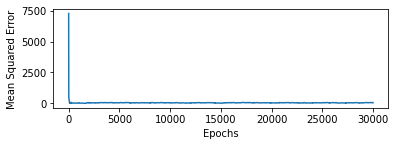

Testing
Testing MSE is  114.7630013088146
Testing MAE is  3.248905766486396


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.5, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/15000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss :  41138354855.48439  MAE Loss : 79.83308746589343
Epoch: 50  MSE Loss :  370037104.9199556  MAE Loss : 11.174240761088363
Epoch: 100  MSE Loss :  164259044.79739094  MAE Loss : 8.364859614749086
Epoch: 150  MSE Loss :  104288259.99976295  MAE Loss : 7.130970339147163
Epoch: 200  MSE Loss :  82689051.66678554  MAE Loss : 6.505274479580518
Epoch: 250  MSE Loss :  63598133.55814799  MAE Loss : 5.829022908959978
Epoch: 300  MSE Loss :  46370886.376026176  MAE Loss : 5.0611636979871095
Epoch: 350  MSE Loss :  33071049.924200363  MAE Loss : 4.3182832585675275
Epoch: 400  MSE Loss :  23092984.77618611  MAE Loss : 3.6298210694249606
Epoch: 450  MSE Loss :  17679316.008363705  MAE Loss : 3.2578163118156747
Epoch: 500  MSE Loss :  12257801.397979561  MAE Loss : 2.8319050052708907
Epoch: 550  MSE Loss :  9436001.20263622  MAE Loss : 2.4589744836535736
Epoch: 600  MSE Loss :  9891781.182706144  MAE Loss : 2.37530983827939
Epoch: 650  MSE Loss :  12549986.553154174  MAE Loss : 2

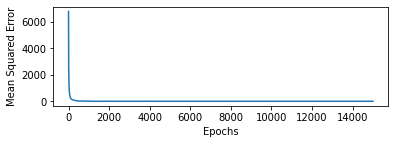

Testing
Testing MSE is  6.609078363523738
Testing MAE is  1.345365400107908


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 15000, learning='GD', regularizer=1, lam=0.1, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/15000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  39970934714.60518  MAE Loss : 79.30895293434763
Epoch: 50  Cost :  534762621.9709503  MAE Loss : 13.551735850328233
Epoch: 100  Cost :  231066848.0296353  MAE Loss : 9.715774604865938
Epoch: 150  Cost :  131591796.79827902  MAE Loss : 7.39137156563161
Epoch: 200  Cost :  91589285.310967  MAE Loss : 6.059963932402184
Epoch: 250  Cost :  72538309.73386243  MAE Loss : 5.38784704438417
Epoch: 300  Cost :  61300098.141648225  MAE Loss : 4.955238970649265
Epoch: 350  Cost :  53563050.370168164  MAE Loss : 4.648262207714537
Epoch: 400  Cost :  47820747.73597017  MAE Loss : 4.422473329390888
Epoch: 450  Cost :  43120017.575053886  MAE Loss : 4.231594926486042
Epoch: 500  Cost :  39134740.72102597  MAE Loss : 4.0685741283766035
Epoch: 550  Cost :  35681800.44291031  MAE Loss : 3.9188017348063733
Epoch: 600  Cost :  32662283.76666177  MAE Loss : 3.7781263745589126
Epoch: 650  Cost :  29986309.92869435  MAE Loss : 3.648070965779076
Epoch: 700  Cost :  27593649.277421944  MAE Los

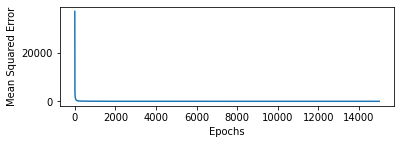

Testing
Testing MSE is  0.9357980230788906
Testing MAE is  0.8436549382570873


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 15000, learning='GD', regularizer=1, lam=0.01, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/20000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  133398488324.09373  MAE Loss : 122.16423242133816
Epoch: 50  Cost :  977885375.6357487  MAE Loss : 19.280828052961382
Epoch: 100  Cost :  689750890.1400665  MAE Loss : 16.720073676395003
Epoch: 150  Cost :  530838668.1776169  MAE Loss : 15.052754728717648
Epoch: 200  Cost :  434267807.3357402  MAE Loss : 13.86465778546547
Epoch: 250  Cost :  370354569.0017358  MAE Loss : 12.947902965225415
Epoch: 300  Cost :  324844414.86891854  MAE Loss : 12.195114848307355
Epoch: 350  Cost :  290406875.12944263  MAE Loss : 11.57389975683741
Epoch: 400  Cost :  263048868.660309  MAE Loss : 11.043722925003673
Epoch: 450  Cost :  240504249.0482134  MAE Loss : 10.578613085567552
Epoch: 500  Cost :  221397524.8953611  MAE Loss : 10.165645813645352
Epoch: 550  Cost :  204902289.74911726  MAE Loss : 9.802163970600127
Epoch: 600  Cost :  190422045.07396477  MAE Loss : 9.476011601134545
Epoch: 650  Cost :  177564570.09598753  MAE Loss : 9.172685518253012
Epoch: 700  Cost :  166056528.1334392

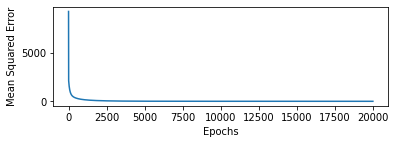

Testing
Testing MSE is  3.8123712458720886
Testing MAE is  1.464235665191212


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 20000, learning='GD', regularizer=1, lam=0.001, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  26812968771.050274  MAE Loss : 63.15486495514356
Epoch: 50  Cost :  276828420.9310677  MAE Loss : 10.816640350393566
Epoch: 100  Cost :  149918559.13414308  MAE Loss : 7.985452497625788
Epoch: 150  Cost :  90402708.51373464  MAE Loss : 6.215101978948287
Epoch: 200  Cost :  63539528.29799598  MAE Loss : 5.211105762571883
Epoch: 250  Cost :  47637918.75834523  MAE Loss : 4.546709964332106
Epoch: 300  Cost :  37816228.52289803  MAE Loss : 4.1250475075783735
Epoch: 350  Cost :  31009245.395184427  MAE Loss : 3.81053247563928
Epoch: 400  Cost :  26015817.41799305  MAE Loss : 3.566589609100765
Epoch: 450  Cost :  22060424.65865243  MAE Loss : 3.356066675050942
Epoch: 500  Cost :  19067085.414728396  MAE Loss : 3.178636672501035
Epoch: 550  Cost :  16834251.252408285  MAE Loss : 3.0358210367900633
Epoch: 600  Cost :  14651056.372416848  MAE Loss : 2.8832599226721185
Epoch: 650  Cost :  12805230.781321647  MAE Loss : 2.739566034158858
Epoch: 700  Cost :  11258415.69186385  MA

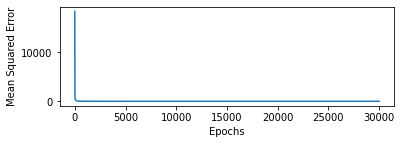

Testing
Testing MSE is  0.9184305078050435
Testing MAE is  0.84015010495091


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.025, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/15000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  19197777659.64077  MAE Loss : 49.22627154733665
Epoch: 50  Cost :  131500726.79192607  MAE Loss : 7.5767393357167965
Epoch: 100  Cost :  94428828.8549118  MAE Loss : 6.564289035776251
Epoch: 150  Cost :  75392226.94723612  MAE Loss : 5.908881300108177
Epoch: 200  Cost :  63562107.43865642  MAE Loss : 5.390494302768742
Epoch: 250  Cost :  55500644.83142345  MAE Loss : 4.984173230831735
Epoch: 300  Cost :  49691397.50385488  MAE Loss : 4.656877069457698
Epoch: 350  Cost :  45159860.258371  MAE Loss : 4.386449839303242
Epoch: 400  Cost :  41390816.85860466  MAE Loss : 4.175761513943196
Epoch: 450  Cost :  38404976.15334384  MAE Loss : 4.036038040291923
Epoch: 500  Cost :  36088643.938121475  MAE Loss : 3.9171480650702453
Epoch: 550  Cost :  34058698.14307043  MAE Loss : 3.836131592920135
Epoch: 600  Cost :  32259865.76422566  MAE Loss : 3.7549626998639267
Epoch: 650  Cost :  30708864.789975557  MAE Loss : 3.681833064268466
Epoch: 700  Cost :  29558062.26476744  MAE Loss 

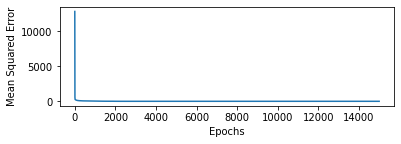

Testing
Testing MSE is  1.419581698684223
Testing MAE is  0.9608328260884754


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 15000, learning='GD', regularizer=1, lam=0.05, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  201493358199.06564  MAE Loss : 126.29870708900947
Epoch: 50  Cost :  168196705.6052901  MAE Loss : 7.6948722687277336
Epoch: 100  Cost :  61885120.484585986  MAE Loss : 4.988664827228137
Epoch: 150  Cost :  34346960.96734015  MAE Loss : 3.8591731477645155
Epoch: 200  Cost :  26002739.98448971  MAE Loss : 3.4130508253025624
Epoch: 250  Cost :  22463346.4050353  MAE Loss : 3.2191684549717174
Epoch: 300  Cost :  19525408.092237934  MAE Loss : 3.031230911583213
Epoch: 350  Cost :  17108534.19692116  MAE Loss : 2.895733123948715
Epoch: 400  Cost :  15005481.685612738  MAE Loss : 2.739132412957756
Epoch: 450  Cost :  11834241.736504083  MAE Loss : 2.4269725677582756
Epoch: 500  Cost :  9799572.724540705  MAE Loss : 2.2299898034513825
Epoch: 550  Cost :  8171631.184188044  MAE Loss : 2.117576737528418
Epoch: 600  Cost :  6869034.412133367  MAE Loss : 2.016056102221808
Epoch: 650  Cost :  6219563.905368574  MAE Loss : 1.9631331678491069
Epoch: 700  Cost :  6058385.791370011  

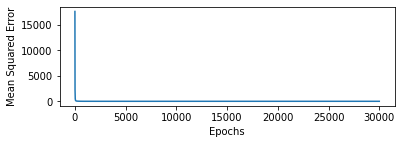

Testing
Testing MSE is  3.672231833169901
Testing MAE is  1.0680006158852835


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.075, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  90484952521.73859  MAE Loss : 94.82835977821028
Epoch: 50  Cost :  1608625162.612119  MAE Loss : 21.362208690497315
Epoch: 100  Cost :  712795554.1448215  MAE Loss : 14.636901264578833
Epoch: 150  Cost :  386937431.83858263  MAE Loss : 10.814901413347929
Epoch: 200  Cost :  255474546.75860837  MAE Loss : 9.136458776693551
Epoch: 250  Cost :  194041008.10126314  MAE Loss : 8.286072406762633
Epoch: 300  Cost :  159823591.10106057  MAE Loss : 7.700859760258367
Epoch: 350  Cost :  137373416.23307863  MAE Loss : 7.234096702013007
Epoch: 400  Cost :  120741314.20172387  MAE Loss : 6.830330252815833
Epoch: 450  Cost :  107468980.32374142  MAE Loss : 6.4718378844389965
Epoch: 500  Cost :  96410622.53171864  MAE Loss : 6.147668241506919
Epoch: 550  Cost :  87161484.03371166  MAE Loss : 5.857061346267931
Epoch: 600  Cost :  79611833.13366228  MAE Loss : 5.603260143080644
Epoch: 650  Cost :  72920979.77019279  MAE Loss : 5.3674320677736596
Epoch: 700  Cost :  66948957.47023477  

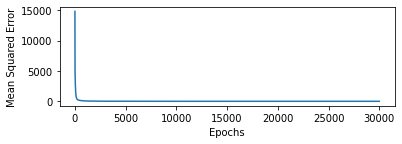

Testing
Testing MSE is  0.9241524668094934
Testing MAE is  0.8428723775642518


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.0125, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  32590994918.03481  MAE Loss : 55.49523331966047
Epoch: 50  Cost :  228770704.50695124  MAE Loss : 9.650516924472804
Epoch: 100  Cost :  177615343.64366737  MAE Loss : 8.589662690116384
Epoch: 150  Cost :  144529254.40932193  MAE Loss : 7.882505234342711
Epoch: 200  Cost :  121922318.68370876  MAE Loss : 7.3644823792474625
Epoch: 250  Cost :  105611587.65951163  MAE Loss : 6.961017085556619
Epoch: 300  Cost :  93210594.54365869  MAE Loss : 6.619870639805888
Epoch: 350  Cost :  83335737.3442439  MAE Loss : 6.32031245536883
Epoch: 400  Cost :  75170203.81337774  MAE Loss : 6.049806686412992
Epoch: 450  Cost :  68220557.28442995  MAE Loss : 5.798018454760457
Epoch: 500  Cost :  62179723.511916  MAE Loss : 5.568373158351093
Epoch: 550  Cost :  56849386.42117965  MAE Loss : 5.351705577299172
Epoch: 600  Cost :  52095774.70406774  MAE Loss : 5.1466428051999245
Epoch: 650  Cost :  47824300.65859445  MAE Loss : 4.9510253571425435
Epoch: 700  Cost :  43964882.102704585  MAE Los

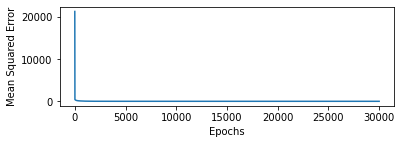

Testing
Testing MSE is  0.929150230199431
Testing MAE is  0.8470875541313384


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.011, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  58347397622.859566  MAE Loss : 69.65958367471094
Epoch: 50  Cost :  672023647.6711022  MAE Loss : 15.00279980365704
Epoch: 100  Cost :  355664006.7317475  MAE Loss : 11.096833728483116
Epoch: 150  Cost :  218824173.63596988  MAE Loss : 8.801673306825087
Epoch: 200  Cost :  152073049.48803005  MAE Loss : 7.316669235537935
Epoch: 250  Cost :  116464451.69445097  MAE Loss : 6.373056580248898
Epoch: 300  Cost :  95961633.62256965  MAE Loss : 5.775371302896426
Epoch: 350  Cost :  83396037.99302964  MAE Loss : 5.3745568393712775
Epoch: 400  Cost :  75235503.22440197  MAE Loss : 5.099785336853262
Epoch: 450  Cost :  69212945.28462811  MAE Loss : 4.894226498254074
Epoch: 500  Cost :  64470511.49721227  MAE Loss : 4.723704204253602
Epoch: 550  Cost :  60534415.040370286  MAE Loss : 4.574944063568294
Epoch: 600  Cost :  57125101.06756831  MAE Loss : 4.4410733901809625
Epoch: 650  Cost :  54073928.66638935  MAE Loss : 4.319000526672133
Epoch: 700  Cost :  51273858.64906554  MAE 

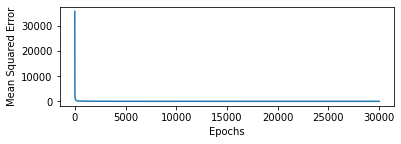

Testing
Testing MSE is  0.9380354345236497
Testing MAE is  0.845480290614012


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.0075, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  63385763030.001396  MAE Loss : 69.33462705847367
Epoch: 50  Cost :  192203193.8605479  MAE Loss : 9.08201635343077
Epoch: 100  Cost :  147272182.95582837  MAE Loss : 7.821167582364628
Epoch: 150  Cost :  126130555.75695571  MAE Loss : 7.146613748981652
Epoch: 200  Cost :  109480668.55648403  MAE Loss : 6.607461563560143
Epoch: 250  Cost :  95822634.04704699  MAE Loss : 6.154648736471799
Epoch: 300  Cost :  84412034.72509943  MAE Loss : 5.767974854252517
Epoch: 350  Cost :  74767415.46456382  MAE Loss : 5.431817091733694
Epoch: 400  Cost :  66551855.984043755  MAE Loss : 5.136621170090776
Epoch: 450  Cost :  59515718.328832455  MAE Loss : 4.875828760250175
Epoch: 500  Cost :  53465931.944502436  MAE Loss : 4.642725466832316
Epoch: 550  Cost :  48390001.49223419  MAE Loss : 4.438318654213835
Epoch: 600  Cost :  44433362.52530954  MAE Loss : 4.275899302212312
Epoch: 650  Cost :  40966585.88135294  MAE Loss : 4.128109108284421
Epoch: 700  Cost :  37925945.4573676  MAE Los

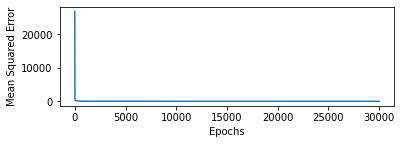

Testing
Testing MSE is  0.9271546696118399
Testing MAE is  0.8445235561637997


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.008, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  37604220755.56207  MAE Loss : 63.25578736869192
Epoch: 50  Cost :  384161188.7296577  MAE Loss : 11.321228003213086
Epoch: 100  Cost :  217414826.1850362  MAE Loss : 8.618150103273262
Epoch: 150  Cost :  134861057.19867584  MAE Loss : 6.979218587680869
Epoch: 200  Cost :  91252657.65845942  MAE Loss : 5.935986954321743
Epoch: 250  Cost :  67045403.86522675  MAE Loss : 5.263577592095638
Epoch: 300  Cost :  53021134.98082902  MAE Loss : 4.84756394806095
Epoch: 350  Cost :  44482331.64183867  MAE Loss : 4.564815483839388
Epoch: 400  Cost :  39000514.93210294  MAE Loss : 4.371892229062273
Epoch: 450  Cost :  35267426.864756875  MAE Loss : 4.22486038487239
Epoch: 500  Cost :  32550088.76032695  MAE Loss : 4.117377419566355
Epoch: 550  Cost :  30438611.2387049  MAE Loss : 4.031394432158015
Epoch: 600  Cost :  28702105.92645367  MAE Loss : 3.9559709723092054
Epoch: 650  Cost :  27207574.709775113  MAE Loss : 3.886880130002499
Epoch: 700  Cost :  25878108.415595654  MAE Loss 

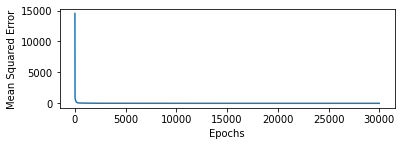

Testing
Testing MSE is  0.9326237479638505
Testing MAE is  0.8452971874792657


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.005, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  16964861939.149458  MAE Loss : 42.07168067424072
Epoch: 50  Cost :  297485145.66929406  MAE Loss : 10.972666039892509
Epoch: 100  Cost :  177025119.14160356  MAE Loss : 8.789321502800354
Epoch: 150  Cost :  113764131.7066235  MAE Loss : 7.214701675371246
Epoch: 200  Cost :  79337977.19531445  MAE Loss : 6.083106787613793
Epoch: 250  Cost :  59815095.411735386  MAE Loss : 5.2584486760459805
Epoch: 300  Cost :  48294989.94556887  MAE Loss : 4.6560993791764895
Epoch: 350  Cost :  41061011.172645226  MAE Loss : 4.211059829110012
Epoch: 400  Cost :  36261476.29726938  MAE Loss : 3.9327055883527113
Epoch: 450  Cost :  32875394.341968775  MAE Loss : 3.769126143899734
Epoch: 500  Cost :  30330795.522252377  MAE Loss : 3.652719837121917
Epoch: 550  Cost :  28303197.48440865  MAE Loss : 3.554193300265675
Epoch: 600  Cost :  26606285.755626697  MAE Loss : 3.4666011743780474
Epoch: 650  Cost :  25131578.850200962  MAE Loss : 3.3852397533240435
Epoch: 700  Cost :  23814759.7245758

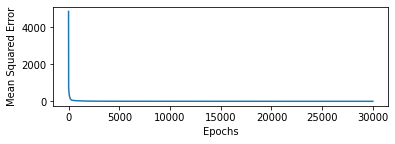

Testing
Testing MSE is  1.1239704761740583
Testing MAE is  0.8859483054440845


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.0025, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/200000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  16924113076.613832  MAE Loss : 51.071184523670496
Epoch: 50  Cost :  1604222965.7928665  MAE Loss : 21.410203720127544
Epoch: 100  Cost :  1432884611.4177167  MAE Loss : 20.245029182202458
Epoch: 150  Cost :  1296061534.243887  MAE Loss : 19.275985148129266
Epoch: 200  Cost :  1174861962.0738044  MAE Loss : 18.396892878077555
Epoch: 250  Cost :  1066404328.7646604  MAE Loss : 17.585341118479626
Epoch: 300  Cost :  968946776.9346148  MAE Loss : 16.8288535789164
Epoch: 350  Cost :  881332082.6774819  MAE Loss : 16.123925968425937
Epoch: 400  Cost :  802535354.3852575  MAE Loss : 15.468778125992033
Epoch: 450  Cost :  731641797.6179945  MAE Loss : 14.852109201005412
Epoch: 500  Cost :  667833970.7219307  MAE Loss : 14.268301824439323
Epoch: 550  Cost :  610380935.3901199  MAE Loss : 13.717683369869448
Epoch: 600  Cost :  558628711.7265338  MAE Loss : 13.194606811781169
Epoch: 650  Cost :  511991880.4936309  MAE Loss : 12.696713036332284
Epoch: 700  Cost :  469946181.8405

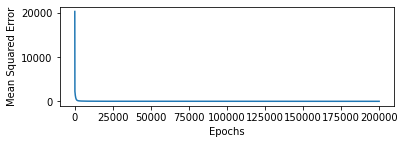

Testing
Testing MSE is  0.9335157744435287
Testing MAE is  0.8470383968887747


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 200000, learning='GD', regularizer=1, lam=0.01, learning_rate=0.000002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  6106937614.6132765  MAE Loss : 38.31752901404295
Epoch: 50  Cost :  532017918.49302524  MAE Loss : 14.115225173843115
Epoch: 100  Cost :  295428348.1958656  MAE Loss : 10.317463782041994
Epoch: 150  Cost :  188766023.39755246  MAE Loss : 8.295268229921836
Epoch: 200  Cost :  138295886.7090172  MAE Loss : 7.373112150887341
Epoch: 250  Cost :  110405226.22663735  MAE Loss : 6.799670069797063
Epoch: 300  Cost :  91868264.60979624  MAE Loss : 6.3480891070862455
Epoch: 350  Cost :  78569004.15907663  MAE Loss : 5.97154701521364
Epoch: 400  Cost :  68429572.55436403  MAE Loss : 5.649196867320658
Epoch: 450  Cost :  60481841.1760712  MAE Loss : 5.370069580325186
Epoch: 500  Cost :  54464540.93520135  MAE Loss : 5.162512525462151
Epoch: 550  Cost :  49922224.62072792  MAE Loss : 4.992170792768259
Epoch: 600  Cost :  46226171.39815364  MAE Loss : 4.820613174391788
Epoch: 650  Cost :  43034537.76558953  MAE Loss : 4.693942687058277
Epoch: 700  Cost :  40083251.10369423  MAE Los

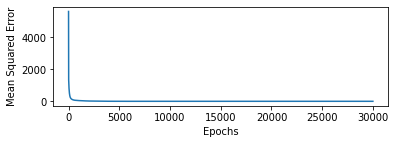

Testing
Testing MSE is  0.9303449855389483
Testing MAE is  0.8415293468389161


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.03, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  8403256417.9924965  MAE Loss : 40.32816515483823
Epoch: 50  Cost :  540316381.29848  MAE Loss : 14.282207336895553
Epoch: 100  Cost :  288574922.5770024  MAE Loss : 10.483163176116783
Epoch: 150  Cost :  189717420.97659862  MAE Loss : 8.8090701678881
Epoch: 200  Cost :  139724192.46638367  MAE Loss : 7.878213897511024
Epoch: 250  Cost :  108571882.71823816  MAE Loss : 7.193466696111648
Epoch: 300  Cost :  86338135.0730517  MAE Loss : 6.623054908035853
Epoch: 350  Cost :  70224273.84212203  MAE Loss : 6.130570242520868
Epoch: 400  Cost :  61760426.93523344  MAE Loss : 5.80944193392616
Epoch: 450  Cost :  54728127.96114496  MAE Loss : 5.5153042474871565
Epoch: 500  Cost :  48424709.413869746  MAE Loss : 5.235147717591456
Epoch: 550  Cost :  42825025.091555245  MAE Loss : 4.96244707492962
Epoch: 600  Cost :  37967486.695226975  MAE Loss : 4.711993786808816
Epoch: 650  Cost :  33490218.14127141  MAE Loss : 4.484867845559909
Epoch: 700  Cost :  29774655.83413173  MAE Loss 

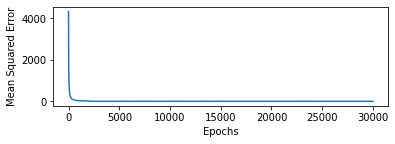

Testing
Testing MSE is  0.9577416879045287
Testing MAE is  0.8518738799901046


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.04, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  18692223373.782566  MAE Loss : 42.948707218829426
Epoch: 50  Cost :  358912665.9064594  MAE Loss : 11.749197343335958
Epoch: 100  Cost :  209756940.8920721  MAE Loss : 9.36666661046878
Epoch: 150  Cost :  138196512.89291683  MAE Loss : 7.9254343811906045
Epoch: 200  Cost :  98781285.8923649  MAE Loss : 6.904394167478168
Epoch: 250  Cost :  73024043.47753964  MAE Loss : 6.114506222238335
Epoch: 300  Cost :  55475001.811234005  MAE Loss : 5.4993522573343965
Epoch: 350  Cost :  43085759.36812231  MAE Loss : 5.0080137681222965
Epoch: 400  Cost :  35005390.595382676  MAE Loss : 4.739745714998912
Epoch: 450  Cost :  28992480.45260206  MAE Loss : 4.48487392205697
Epoch: 500  Cost :  24597226.875224438  MAE Loss : 4.240660165427949
Epoch: 550  Cost :  21100746.081812773  MAE Loss : 3.99883349195099
Epoch: 600  Cost :  18631837.97631115  MAE Loss : 3.795690714577598
Epoch: 650  Cost :  16059979.85994919  MAE Loss : 3.556244586556976
Epoch: 700  Cost :  13365175.64512579  MAE L

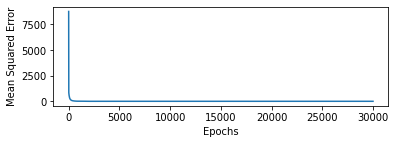

Testing
Testing MSE is  2.454444094767765
Testing MAE is  0.9957822696502777


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.06, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  34960441816.22171  MAE Loss : 50.61280348803967
Epoch: 50  Cost :  131022419.70792073  MAE Loss : 7.0574655986891885
Epoch: 100  Cost :  64516197.43633685  MAE Loss : 5.388208195122778
Epoch: 150  Cost :  47342170.47704463  MAE Loss : 4.779518366811483
Epoch: 200  Cost :  37147530.99489587  MAE Loss : 4.368366126443712
Epoch: 250  Cost :  30709285.76463605  MAE Loss : 4.051043056189716
Epoch: 300  Cost :  26487793.999125943  MAE Loss : 3.8031265709240825
Epoch: 350  Cost :  23620747.380657736  MAE Loss : 3.6006972193615185
Epoch: 400  Cost :  21575792.305102076  MAE Loss : 3.434808748179824
Epoch: 450  Cost :  20031221.552613392  MAE Loss : 3.2963326509258946
Epoch: 500  Cost :  18824247.15352951  MAE Loss : 3.1791460519511983
Epoch: 550  Cost :  17832896.12621579  MAE Loss : 3.077072593467667
Epoch: 600  Cost :  17002269.479536958  MAE Loss : 2.9945892435282366
Epoch: 650  Cost :  16294708.325836757  MAE Loss : 2.9251512884658237
Epoch: 700  Cost :  15681337.40480311

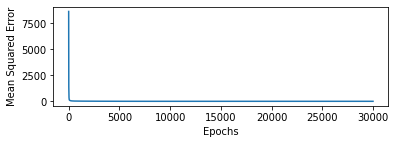

Testing
Testing MSE is  0.9297191483526199
Testing MAE is  0.8456256196320159


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.012, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  6872403262.041911  MAE Loss : 38.588585171572305
Epoch: 50  Cost :  301554596.81952286  MAE Loss : 10.108636859013423
Epoch: 100  Cost :  146037513.1214052  MAE Loss : 7.24517206527782
Epoch: 150  Cost :  102888867.49770123  MAE Loss : 6.076217590296374
Epoch: 200  Cost :  83948067.93080008  MAE Loss : 5.624640009454712
Epoch: 250  Cost :  73293844.17328586  MAE Loss : 5.362878780872909
Epoch: 300  Cost :  65945185.47532733  MAE Loss : 5.166081370692511
Epoch: 350  Cost :  60208433.41984519  MAE Loss : 4.995358837644741
Epoch: 400  Cost :  55775566.9600747  MAE Loss : 4.853183233222092
Epoch: 450  Cost :  51966758.177026205  MAE Loss : 4.726934253052051
Epoch: 500  Cost :  48581136.41200448  MAE Loss : 4.608262874960267
Epoch: 550  Cost :  45549711.06983278  MAE Loss : 4.49438338408117
Epoch: 600  Cost :  42813012.289146006  MAE Loss : 4.386364652525248
Epoch: 650  Cost :  40322833.84550631  MAE Loss : 4.28541418702367
Epoch: 700  Cost :  38378139.226963066  MAE Loss 

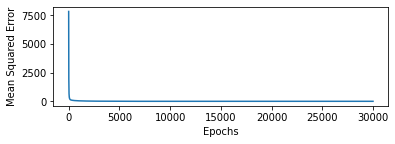

Testing
Testing MSE is  0.9358569336272994
Testing MAE is  0.8444711928202384


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.015, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  80171196971.72029  MAE Loss : 78.7096360271879
Epoch: 50  Cost :  523750031.6075082  MAE Loss : 12.156041308548009
Epoch: 100  Cost :  439842710.3425657  MAE Loss : 11.212194239152419
Epoch: 150  Cost :  379761637.1113172  MAE Loss : 10.471462788967537
Epoch: 200  Cost :  329229817.39656055  MAE Loss : 9.772935757419019
Epoch: 250  Cost :  285683852.02378047  MAE Loss : 9.120678519418593
Epoch: 300  Cost :  248331584.02949706  MAE Loss : 8.517999719256693
Epoch: 350  Cost :  216082659.94998452  MAE Loss : 7.954719969326394
Epoch: 400  Cost :  188129649.57514092  MAE Loss : 7.429821237073116
Epoch: 450  Cost :  163845956.51404104  MAE Loss : 6.939178534092946
Epoch: 500  Cost :  142764071.9257472  MAE Loss : 6.480737598591337
Epoch: 550  Cost :  124386040.54069781  MAE Loss : 6.062791857008478
Epoch: 600  Cost :  108444808.44298373  MAE Loss : 5.671884201015773
Epoch: 650  Cost :  94685085.76525822  MAE Loss : 5.325813158725059
Epoch: 700  Cost :  82695543.92045398  MA

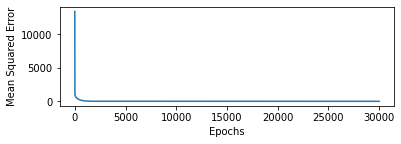

Testing
Testing MSE is  0.9227120577318548
Testing MAE is  0.8429069792229316


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, lam=0.0175, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans , test_y)

### RMSE vs Lambda - Lasso Regression

In [ ]:
def rmse(Y, Y_pred):
    return np.sum((1/Y.shape[0]) * ((Y_pred - Y)**2) )**0.5

rms_train = []
rms_test = []
lam = []
for i in range(5, 250, 5):   
    i = i/10000
    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, display_loss=False, lam=i, learning_rate=0.00002)
    x_test_trans = GD_Reg_1.transform(test_X)
    y_test_pred = GD_Reg_1.predict(x_test_trans)
    y_train_pred = GD_Reg_1.predict(x_train_trans)
    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train.append(rmse_train)
    rms_test.append(rmse_test)
    lam.append(i)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0005  RMSE train :  1.2540499961921414  RMSE test :  1.311619363361225
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.001  RMSE train :  1.4040016070473018  RMSE test :  1.425000658521397
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0015  RMSE train :  1.138684505306867  RMSE test :  1.1708766884533723
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.002  RMSE train :  1.1567333950598784  RMSE test :  1.1562618355755894
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0025  RMSE train :  0.9135837023453093  RMSE test :  0.9251791591033075
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.003  RMSE train :  0.8793808628120203  RMSE test :  0.8749183871307579
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0035  RMSE train :  0.9928941318505785  RMSE test :  1.0282414373986675
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.004  RMSE train :  0.9776165878726554  RMSE test :  0.9866088523404096
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0045  RMSE train :  0.8628787642391207  RMSE test :  0.8811152811649698
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.005  RMSE train :  0.960477637977524  RMSE test :  0.9662023462504427
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0055  RMSE train :  0.9579376851955282  RMSE test :  0.9668606764287195
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.006  RMSE train :  0.9585339591573462  RMSE test :  0.965916466861649
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0065  RMSE train :  0.9580088746484574  RMSE test :  0.9674201334883473
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.007  RMSE train :  0.9580083212136683  RMSE test :  0.9690153955397783
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0075  RMSE train :  0.9589085399782818  RMSE test :  0.9645072778473529
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.008  RMSE train :  0.9591355628946694  RMSE test :  0.9654123497543445
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0085  RMSE train :  0.9586148215600468  RMSE test :  0.9791545205327263
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.009  RMSE train :  0.9583047731374259  RMSE test :  0.963501658801845
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0095  RMSE train :  0.9610452656420417  RMSE test :  0.9632861674663695
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.01  RMSE train :  0.9573719647007887  RMSE test :  0.978229082394697
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0105  RMSE train :  0.9644177336485532  RMSE test :  0.9632043781679146
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.011  RMSE train :  0.9646193216444895  RMSE test :  0.9641371456978438
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0115  RMSE train :  0.9632147293284908  RMSE test :  0.9630744009388653
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.012  RMSE train :  0.9597444748900569  RMSE test :  0.9608714402924763
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0125  RMSE train :  0.9646121044395367  RMSE test :  0.964491135030299
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.013  RMSE train :  0.9620528325745072  RMSE test :  0.9658619381913521
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0135  RMSE train :  0.9618703977493955  RMSE test :  0.9608568778077793
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.014  RMSE train :  0.9734455855807251  RMSE test :  0.9731213710172213
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0145  RMSE train :  0.9591490111963912  RMSE test :  0.9745151563503401
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.015  RMSE train :  0.9617585300971161  RMSE test :  0.9603833739219385
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0155  RMSE train :  0.9626259033993058  RMSE test :  0.9605909137358742
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.016  RMSE train :  0.9658885489262965  RMSE test :  0.9641589505041277
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0165  RMSE train :  0.9664778112113476  RMSE test :  0.964534249282682
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.017  RMSE train :  0.9570984622422317  RMSE test :  0.9638450480341978
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0175  RMSE train :  0.9604771674110638  RMSE test :  0.9627103588644608
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.018  RMSE train :  0.9684379333321621  RMSE test :  0.9663358753437248
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0185  RMSE train :  0.9562281118630891  RMSE test :  0.963505986879185
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.019  RMSE train :  0.9651490222485917  RMSE test :  0.9629956588026234
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0195  RMSE train :  0.9702118049934042  RMSE test :  0.9670560567680271
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.02  RMSE train :  0.9671212718456491  RMSE test :  0.9630260759434356
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0205  RMSE train :  0.984339455685133  RMSE test :  0.9874322511561167
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.021  RMSE train :  0.9589941614191017  RMSE test :  0.9575635421001395
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0215  RMSE train :  0.9546452166896532  RMSE test :  0.9691334523812429
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.022  RMSE train :  0.9803729905192374  RMSE test :  0.9804909232316377
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0225  RMSE train :  0.9632978331804788  RMSE test :  0.9626730402816381
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.023  RMSE train :  0.9764292378802498  RMSE test :  0.9768700532224364
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0235  RMSE train :  0.9625810660436633  RMSE test :  0.9623796109571866
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.024  RMSE train :  0.971380704212016  RMSE test :  0.9700255570856805
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0245  RMSE train :  0.9622514895742863  RMSE test :  0.9602050132093388


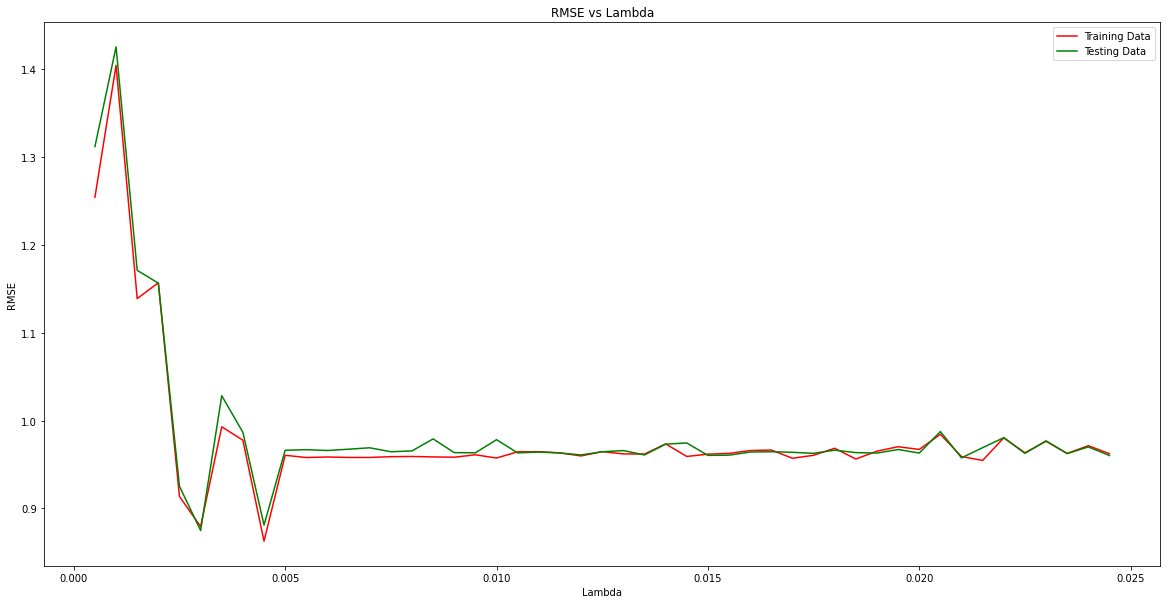

In [ ]:
## 0.0005 to 0.025
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(lam, rms_train, "r", label="Training Data")
ax.plot(lam, rms_test, "g", label = "Testing Data")
plt.title("RMSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSE")
leg = ax.legend()
plt.show()

In [ ]:
def rmse(Y, Y_pred):
    return np.sum((1/Y.shape[0]) * ((Y_pred - Y)**2) )**0.5

rms_train = []
rms_test = []
lam = []
for i in range(250, 10000, 200):   
    i = i/10000
    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, display_loss=False, lam=i, learning_rate=0.00002)
    x_test_trans = GD_Reg_1.transform(test_X)
    y_test_pred = GD_Reg_1.predict(x_test_trans)
    y_train_pred = GD_Reg_1.predict(x_train_trans)
    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train.append(rmse_train)
    rms_test.append(rmse_test)
    lam.append(i)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.025  RMSE train :  0.9642277944966409  RMSE test :  0.9651554480420896
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.045  RMSE train :  1.0661392299570218  RMSE test :  1.1334122074307322
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.065  RMSE train :  1.1071135472241653  RMSE test :  1.4083761960255594
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.085  RMSE train :  1.7161678563134009  RMSE test :  2.5200311625094978
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.105  RMSE train :  1.8634548093127996  RMSE test :  2.5302074456731902
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.125  RMSE train :  1.6464962125898968  RMSE test :  2.4314125415549603
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.145  RMSE train :  2.403393110935558  RMSE test :  3.411856509571755
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.165  RMSE train :  2.114876941643476  RMSE test :  3.2305080732489984
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.185  RMSE train :  2.595888658002617  RMSE test :  4.0016548594156145
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.205  RMSE train :  3.1861100689575372  RMSE test :  4.655486687788917
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.225  RMSE train :  3.1748515060998246  RMSE test :  4.877688839424585
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.245  RMSE train :  3.8600111598509788  RMSE test :  5.784739355997167
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.265  RMSE train :  4.110789906235285  RMSE test :  6.421798707249691
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.285  RMSE train :  4.252414446634462  RMSE test :  6.561386318455218
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.305  RMSE train :  5.0415432322830815  RMSE test :  7.8167979894559965
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.325  RMSE train :  3.918696986505565  RMSE test :  6.093599136404863
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.345  RMSE train :  4.620127741695846  RMSE test :  7.243886643249971
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.365  RMSE train :  5.365362350819337  RMSE test :  7.9756255201862825
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.385  RMSE train :  4.692599539201455  RMSE test :  7.105411509448423
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.405  RMSE train :  6.8031863964647625  RMSE test :  10.271171617929944
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.425  RMSE train :  6.510666722826541  RMSE test :  10.11983832200332
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.445  RMSE train :  6.113694567296991  RMSE test :  9.558683728289202
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.465  RMSE train :  6.8360055962784845  RMSE test :  10.428510134624016
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.485  RMSE train :  7.0336364174726835  RMSE test :  10.711346041513805
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.505  RMSE train :  7.145072820165527  RMSE test :  11.14009387200233
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.525  RMSE train :  7.421171937941654  RMSE test :  11.621828737108878
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.545  RMSE train :  7.959544907430946  RMSE test :  12.372719268078166
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.565  RMSE train :  5.0640331965028595  RMSE test :  8.041641997750657
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.585  RMSE train :  8.85600127799153  RMSE test :  13.750783276316456
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.605  RMSE train :  3.736449891237818  RMSE test :  5.604748562932412
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.625  RMSE train :  10.45955155397364  RMSE test :  16.227586177738818
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.645  RMSE train :  3.392155617603978  RMSE test :  5.378864649960404
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.665  RMSE train :  8.770971775805936  RMSE test :  13.523216243436417
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.685  RMSE train :  8.24245135709901  RMSE test :  12.81063193779086
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.705  RMSE train :  11.021676286285757  RMSE test :  17.214209136854276
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.725  RMSE train :  8.187245259730103  RMSE test :  12.930021725227562
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.745  RMSE train :  8.946597019244752  RMSE test :  13.649836727046088
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.765  RMSE train :  8.866267017960094  RMSE test :  13.845467177432537
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.785  RMSE train :  7.754462484258404  RMSE test :  12.207627987471147
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.805  RMSE train :  9.848438037758191  RMSE test :  15.53242451319834
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.825  RMSE train :  12.308789120707102  RMSE test :  19.214019969035352
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.845  RMSE train :  11.442487638211148  RMSE test :  17.91728662242485
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.865  RMSE train :  9.355627479462543  RMSE test :  14.400864271769938
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.885  RMSE train :  9.65235355133811  RMSE test :  14.83693946881543
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.905  RMSE train :  8.982559051888407  RMSE test :  13.960300109426955
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.925  RMSE train :  13.303530463254223  RMSE test :  20.59282025174314
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.945  RMSE train :  14.827504642308869  RMSE test :  22.91499412051125
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.965  RMSE train :  13.976262839778473  RMSE test :  21.567988152443558
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.985  RMSE train :  12.952353963793515  RMSE test :  20.282629877025883


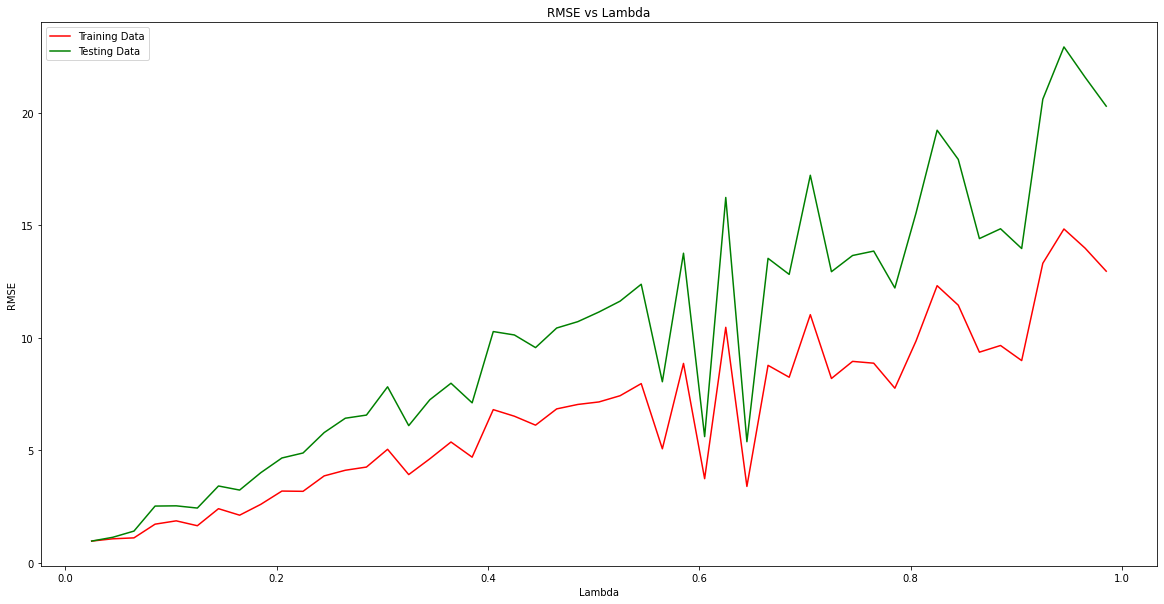

In [ ]:
## From 0.025 to 1
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(lam, rms_train, "r", label="Training Data")
ax.plot(lam, rms_test, "g", label = "Testing Data")
plt.title("RMSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSE")
leg = ax.legend()
plt.show()

In [ ]:
for i in range(0, 250, 10):   
    i = i/10000
    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 30000, learning='GD', regularizer=1, display_loss=False, lam=i, learning_rate=0.00002)
    x_test_trans = GD_Reg_1.transform(test_X)
    y_test_pred = GD_Reg_1.predict(x_test_trans)
    y_train_pred = GD_Reg_1.predict(x_train_trans)
    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train.insert(0,rmse_train)
    rms_test.insert(0, rmse_test)
    lam.insert(0, i)

Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0  RMSE train :  1.9758685368596036  RMSE test :  1.9190764987724886
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.001  RMSE train :  1.2950520885876404  RMSE test :  1.304137837474431
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.002  RMSE train :  1.2580809406356774  RMSE test :  1.3164657314915904
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.003  RMSE train :  0.9450895100470906  RMSE test :  0.9390261653208533
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.004  RMSE train :  0.9588311492287522  RMSE test :  0.9680045487106861
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.005  RMSE train :  0.9040321424038936  RMSE test :  0.9124781317492957
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.006  RMSE train :  0.9608695672362094  RMSE test :  0.9674344539912795
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.007  RMSE train :  0.9600702306386965  RMSE test :  0.9650183248036788
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.008  RMSE train :  0.9595716764916723  RMSE test :  0.9639179370053755
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.009  RMSE train :  0.9590724761454912  RMSE test :  0.9666595992980405
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.01  RMSE train :  0.9596800558534747  RMSE test :  0.9631571217174674
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.011  RMSE train :  0.960434875966045  RMSE test :  0.9621523595989708
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.012  RMSE train :  0.959265300920497  RMSE test :  0.9621000179118118
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.013  RMSE train :  0.9588844693246639  RMSE test :  0.9622704594876453
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.014  RMSE train :  0.9652238945342723  RMSE test :  0.9645998796106323
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.015  RMSE train :  0.9629083107247536  RMSE test :  0.9641650548964928
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.016  RMSE train :  0.966023212920538  RMSE test :  0.964060356142606
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.017  RMSE train :  0.9637011356997691  RMSE test :  0.9627364791438447
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.018  RMSE train :  0.9632511509575662  RMSE test :  0.9636192779129805
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.019  RMSE train :  0.97822833531762  RMSE test :  0.9784821856437474
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.02  RMSE train :  0.9642011787932875  RMSE test :  0.9610001779400267
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.021  RMSE train :  0.9603011991654429  RMSE test :  0.9607630568820661
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.022  RMSE train :  0.9851924191552046  RMSE test :  0.9882240991699782
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.023  RMSE train :  0.9654514754664673  RMSE test :  0.9631422356171662
Training...


  0%|          | 0/30000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.024  RMSE train :  0.962025153577619  RMSE test :  0.9631519986108203


In [ ]:
l1 = lam[:25]
l2 = lam[25:]
l1.reverse()
l1.extend(l2)
print(l1)
rms_tr1 = rms_test[:25]
rms_tr2 = rms_test[25:]
rms_tr1.reverse()
rms_tr1.extend(rms_tr2)
rms_t1 = rms_train[:25]
rms_t2 = rms_train[25:]
rms_t1.reverse()
rms_t1.extend(rms_t2)

[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.045, 0.065, 0.085, 0.105, 0.125, 0.145, 0.165, 0.185, 0.205, 0.225, 0.245, 0.265, 0.285, 0.305, 0.325, 0.345, 0.365, 0.385, 0.405, 0.425, 0.445, 0.465, 0.485, 0.505, 0.525, 0.545, 0.565, 0.585, 0.605, 0.625, 0.645, 0.665, 0.685, 0.705, 0.725, 0.745, 0.765, 0.785, 0.805, 0.825, 0.845, 0.865, 0.885, 0.905, 0.925, 0.945, 0.965, 0.985]


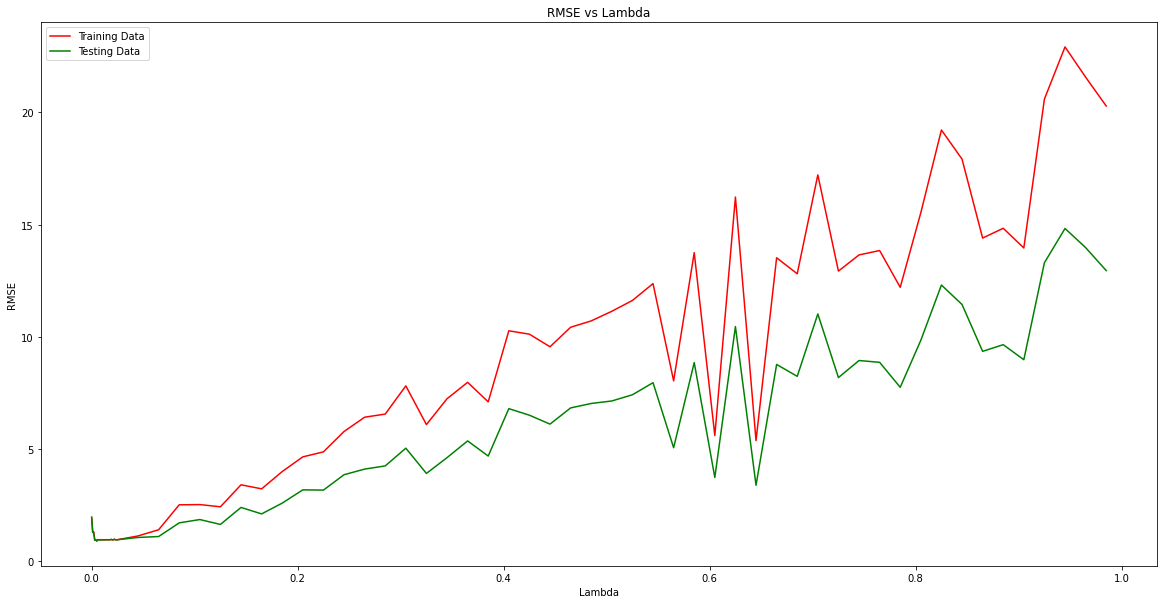

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(l1, rms_tr1, "r", label="Training Data")
ax.plot(l1, rms_t1, "g", label = "Testing Data")
plt.title("RMSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSE")
leg = ax.legend()
plt.show()

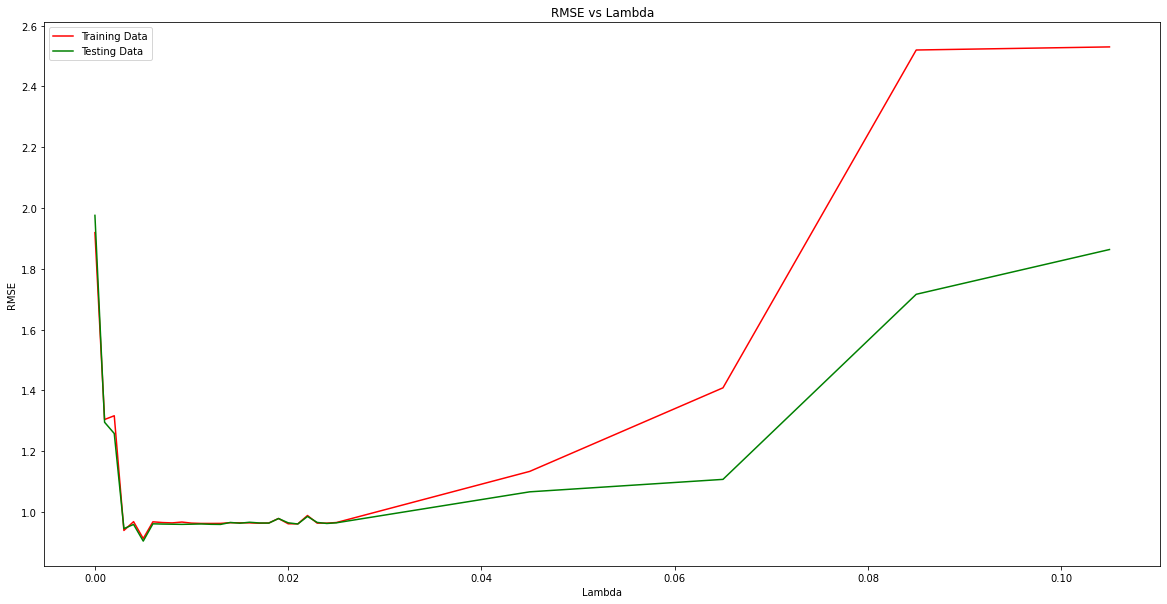

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(l1[:30], rms_tr1[:30], "r", label="Training Data")
ax.plot(l1[:30], rms_t1[:30], "g", label = "Testing Data")
plt.title("RMSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSE")
leg = ax.legend()
plt.show()

In [ ]:
print('Best Lambda :', l1[5], 'with RMSE', rms_t1[5])

Best Lambda : 0.005 with RMSE 0.9040321424038936


In [ ]:
rms_results = []
rms_results.append(l1)
rms_results.append(rms_tr1)
rms_results.append(rms_t1)
rms_results = np.array(rms_results)
file = '/content/gdrive/My Drive/3-1/FoDS/FODSAssignment/rmseVsLambda.csv'
np.savetxt(file, rms_results, delimiter=",")

### Ridge Regression

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  367657.0206470078  MAE Loss : 0.5767399014771434
Epoch: 750050  Cost :  367635.16222834977  MAE Loss : 0.5767232708778605
Epoch: 750100  Cost :  367613.3068760894  MAE Loss : 0.576706641443887
Epoch: 750150  Cost :  367591.45458967664  MAE Loss : 0.5766900131751254
Epoch: 750200  Cost :  367569.6053685626  MAE Loss : 0.5766733860714777
Epoch: 750250  Cost :  367547.7592121964  MAE Loss : 0.5766567601328464
Epoch: 750300  Cost :  367525.91612002964  MAE Loss : 0.5766401353591344
Epoch: 750350  Cost :  367504.0760915122  MAE Loss : 0.5766235117502434
Epoch: 750400  Cost :  367482.23912609566  MAE Loss : 0.5766068893060774
Epoch: 750450  Cost :  367460.40522322943  MAE Loss : 0.576590268026537
Epoch: 750500  Cost :  367438.57438236603  MAE Loss : 0.5765736479115262
Epoch: 750550  Cost :  367416.7466029555  MAE Loss : 0.5765570289609468
Epoch: 750600  Cost :  367394.9218844502  MAE Loss : 0.576540411174702
Epoch: 750

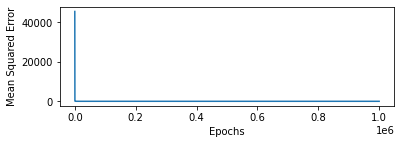

Testing
Testing MSE is  0.39743513759446597
Testing MAE is  0.508853640126366


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.5, regularizer=2, learning_rate=0.00002)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  442520.9890457722  MAE Loss : 0.6499194029988266
Epoch: 750050  Cost :  442500.11610753724  MAE Loss : 0.6499054203634265
Epoch: 750100  Cost :  442479.2451626182  MAE Loss : 0.6498914383777604
Epoch: 750150  Cost :  442458.3762107555  MAE Loss : 0.6498774570417849
Epoch: 750200  Cost :  442437.5092517028  MAE Loss : 0.6498634763554564
Epoch: 750250  Cost :  442416.6442852045  MAE Loss : 0.6498494963187345
Epoch: 750300  Cost :  442395.78131100984  MAE Loss : 0.6498355169315762
Epoch: 750350  Cost :  442374.92032886285  MAE Loss : 0.6498215381939394
Epoch: 750400  Cost :  442354.06133851607  MAE Loss : 0.6498075601057862
Epoch: 750450  Cost :  442333.20433970954  MAE Loss : 0.6497935826670674
Epoch: 750500  Cost :  442312.3493321988  MAE Loss : 0.649779605877746
Epoch: 750550  Cost :  442291.4963157296  MAE Loss : 0.6497656297377803
Epoch: 750600  Cost :  442270.6452900456  MAE Loss : 0.6497516542471253
Epoch: 75

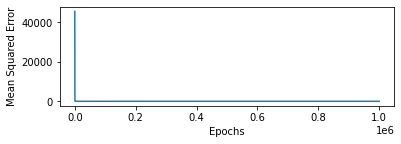

Testing
Testing MSE is  0.5882250888115425
Testing MAE is  0.6172027901734951


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.25, regularizer=2, learning_rate=0.00001)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  207808.8662854683  MAE Loss : 0.4477370710748931
Epoch: 750050  Cost :  207802.47676511036  MAE Loss : 0.44772995012402644
Epoch: 750100  Cost :  207796.0882846523  MAE Loss : 0.44772282976920624
Epoch: 750150  Cost :  207789.70084386854  MAE Loss : 0.44771571001036176
Epoch: 750200  Cost :  207783.3144425368  MAE Loss : 0.4477085908474245
Epoch: 750250  Cost :  207776.9290804305  MAE Loss : 0.4477014722803223
Epoch: 750300  Cost :  207770.5447573276  MAE Loss : 0.44769435430898874
Epoch: 750350  Cost :  207764.16147300196  MAE Loss : 0.44768723693334983
Epoch: 750400  Cost :  207757.77922723014  MAE Loss : 0.447680120153338
Epoch: 750450  Cost :  207751.39801978876  MAE Loss : 0.447673003968884
Epoch: 750500  Cost :  207745.0178504526  MAE Loss : 0.4476658883799172
Epoch: 750550  Cost :  207738.63871899975  MAE Loss : 0.44765877338636784
Epoch: 750600  Cost :  207732.26062520323  MAE Loss : 0.44765165898816456
E

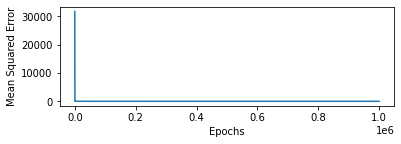

Testing
Testing MSE is  0.2952476995106605
Testing MAE is  0.43632592220817457


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.1, regularizer=2, learning_rate=0.000025)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  215075.56519950298  MAE Loss : 0.46338992363445014
Epoch: 750050  Cost :  215070.21032189188  MAE Loss : 0.4633844326368848
Epoch: 750100  Cost :  215064.85609894636  MAE Loss : 0.46337894193372137
Epoch: 750150  Cost :  215059.50253053728  MAE Loss : 0.4633734515249372
Epoch: 750200  Cost :  215054.14961653497  MAE Loss : 0.4633679614105148
Epoch: 750250  Cost :  215048.79735681045  MAE Loss : 0.4633624715904287
Epoch: 750300  Cost :  215043.44575123262  MAE Loss : 0.4633569820646589
Epoch: 750350  Cost :  215038.09479967327  MAE Loss : 0.46335149283318366
Epoch: 750400  Cost :  215032.74450200278  MAE Loss : 0.46334600389598096
Epoch: 750450  Cost :  215027.39485809067  MAE Loss : 0.4633405152530293
Epoch: 750500  Cost :  215022.04586780895  MAE Loss : 0.4633350269043078
Epoch: 750550  Cost :  215016.69753102644  MAE Loss : 0.46332953884979433
Epoch: 750600  Cost :  215011.34984761567  MAE Loss : 0.463324051089

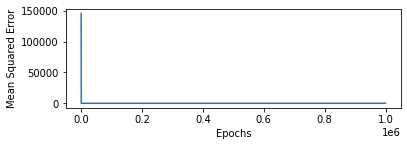

Testing
Testing MSE is  0.3541295542453693
Testing MAE is  0.47381241629622656


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.05, regularizer=2, learning_rate=0.000025)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  200419.28313375675  MAE Loss : 0.4434371013658025
Epoch: 750050  Cost :  200414.74783411363  MAE Loss : 0.4434321623380975
Epoch: 750100  Cost :  200410.21311254468  MAE Loss : 0.44342722361721754
Epoch: 750150  Cost :  200405.67896895015  MAE Loss : 0.4434222852031489
Epoch: 750200  Cost :  200401.14540322404  MAE Loss : 0.4434173470958553
Epoch: 750250  Cost :  200396.61241526803  MAE Loss : 0.4434124092953195
Epoch: 750300  Cost :  200392.0800049769  MAE Loss : 0.44340747180150714
Epoch: 750350  Cost :  200387.5481722532  MAE Loss : 0.44340253461439755
Epoch: 750400  Cost :  200383.01691699005  MAE Loss : 0.44339759773396176
Epoch: 750450  Cost :  200378.486239089  MAE Loss : 0.4433926611601808
Epoch: 750500  Cost :  200373.95613844733  MAE Loss : 0.44338772489301986
Epoch: 750550  Cost :  200369.42661496223  MAE Loss : 0.4433827889324618
Epoch: 750600  Cost :  200364.89766853282  MAE Loss : 0.4433778532784723

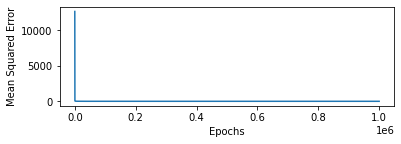

Testing
Testing MSE is  0.31848054205250786
Testing MAE is  0.44960352079813387


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.025, regularizer=2, learning_rate=0.000025)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  264977.6252463153  MAE Loss : 0.48184030062660743
Epoch: 750050  Cost :  264966.71756844927  MAE Loss : 0.4818314430395604
Epoch: 750100  Cost :  264955.8113564672  MAE Loss : 0.4818225860515306
Epoch: 750150  Cost :  264944.90661009727  MAE Loss : 0.48181372966245684
Epoch: 750200  Cost :  264934.0033290671  MAE Loss : 0.4818048738722765
Epoch: 750250  Cost :  264923.10151310585  MAE Loss : 0.4817960186809317
Epoch: 750300  Cost :  264912.201161941  MAE Loss : 0.48178716408835853
Epoch: 750350  Cost :  264901.30227530154  MAE Loss : 0.4817783100944972
Epoch: 750400  Cost :  264890.4048529153  MAE Loss : 0.4817694566992864
Epoch: 750450  Cost :  264879.50889451185  MAE Loss : 0.48176060390266556
Epoch: 750500  Cost :  264868.61439981865  MAE Loss : 0.481751751704572
Epoch: 750550  Cost :  264857.72136856493  MAE Loss : 0.4817429001049462
Epoch: 750600  Cost :  264846.8298004789  MAE Loss : 0.48173404910372675
Epo

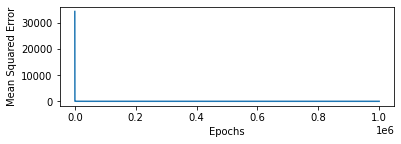

Testing
Testing MSE is  0.32957515938599563
Testing MAE is  0.4541464043289037


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.01, regularizer=2, learning_rate=0.000025)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

In [ ]:
GD_Reg_1.w

array([ 0.10491042,  0.07644156,  0.2993911 ,  2.14237982, -1.27281278,
       -0.88213389,  1.23594769, -0.13005766, -0.35128577,  0.02826933,
       -0.35048   , -2.00198084, -0.61141461,  0.62903492,  0.66837651,
       -0.30560749,  0.5531001 ,  0.46974943,  0.12502384,  0.03379292,
       -0.50173625,  1.96425254, -1.1239375 , -0.48052904, -0.31896215,
       -1.03158451, -0.69779301, -1.18530202, -0.33317864,  0.30942972,
        0.23006075,  0.14506485,  0.87482818,  0.84220593,  0.41360121,
        0.70236615, -0.30304376,  0.43842039,  0.18629771, -0.37688795,
        0.37147473, -0.5203426 , -0.89025073, -0.47332691,  0.36616171,
        0.15984195,  0.29597253,  0.08110509, -0.62062766, -0.09111754,
        0.18960858,  0.39843246, -0.0720488 , -0.0472273 , -0.01439814])

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  170304.50792563963  MAE Loss : 0.40249480224904144
Epoch: 750050  Cost :  170301.71692600113  MAE Loss : 0.4024919137013755
Epoch: 750100  Cost :  170298.92636973303  MAE Loss : 0.4024890253602543
Epoch: 750150  Cost :  170296.13625673167  MAE Loss : 0.4024861372256529
Epoch: 750200  Cost :  170293.34658689608  MAE Loss : 0.40248324929754903
Epoch: 750250  Cost :  170290.55736012274  MAE Loss : 0.4024803615759248
Epoch: 750300  Cost :  170287.76857630923  MAE Loss : 0.40247747406075585
Epoch: 750350  Cost :  170284.9802353518  MAE Loss : 0.4024745867520185
Epoch: 750400  Cost :  170282.19233715013  MAE Loss : 0.4024716996496946
Epoch: 750450  Cost :  170279.404881601  MAE Loss : 0.40246881275376006
Epoch: 750500  Cost :  170276.6178685999  MAE Loss : 0.4024659260641921
Epoch: 750550  Cost :  170273.83129804643  MAE Loss : 0.4024630616284366
Epoch: 750600  Cost :  170271.04516983897  MAE Loss : 0.40246025152145304

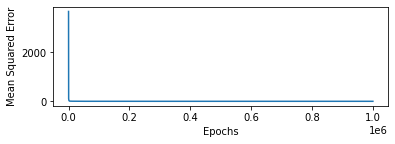

Testing
Testing MSE is  0.2521446751271784
Testing MAE is  0.3988092138373627


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.001, regularizer=2, learning_rate=0.000025)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

In [ ]:
GD_Reg_1.w

array([-0.1607739 ,  1.72859734,  0.07068228, -0.38849192, -0.17206323,
        0.06488736,  0.43037034, -0.454635  , -0.13894292,  0.30863041,
       -1.25740445, -0.19949339, -0.43262198, -0.04780222,  0.62923304,
        0.17237184,  0.2944028 ,  0.07870531, -1.18780173,  0.81191722,
        0.15007118, -0.61172578, -0.58741937, -1.17936224,  2.1100708 ,
       -0.39670473,  1.68687196, -0.67002975,  0.65307208, -1.47294722,
        0.96945078, -0.90909992,  1.55272572, -0.82869181, -0.64974774,
        0.77004632, -0.21918868,  0.27918976, -1.64614409, -2.25017572,
        0.31315737,  0.14716041, -0.19454882,  0.2994272 ,  2.43135702,
        0.02326574, -0.08809262,  0.40859358,  0.52380233,  0.01194879,
       -0.23180275, -1.63654226,  0.02924357,  0.74742173, -0.10582925])

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  253319.5129961372  MAE Loss : 0.4994087733553851
Epoch: 750050  Cost :  253307.63025478623  MAE Loss : 0.499398316027266
Epoch: 750100  Cost :  253295.74902837694  MAE Loss : 0.4993878593446264
Epoch: 750150  Cost :  253283.86931667686  MAE Loss : 0.4993774033074203
Epoch: 750200  Cost :  253271.99111945048  MAE Loss : 0.4993669479155961
Epoch: 750250  Cost :  253260.11443646494  MAE Loss : 0.4993564931691082
Epoch: 750300  Cost :  253248.2392674878  MAE Loss : 0.49934604308145836
Epoch: 750350  Cost :  253236.36561228128  MAE Loss : 0.4993356142274126
Epoch: 750400  Cost :  253224.49347061545  MAE Loss : 0.4993251860173725
Epoch: 750450  Cost :  253212.62284225796  MAE Loss : 0.49931475845128775
Epoch: 750500  Cost :  253200.7537269706  MAE Loss : 0.499304331529112
Epoch: 750550  Cost :  253188.88612452307  MAE Loss : 0.4992939052507995
Epoch: 750600  Cost :  253177.02003468145  MAE Loss : 0.4992834796163004
Epo

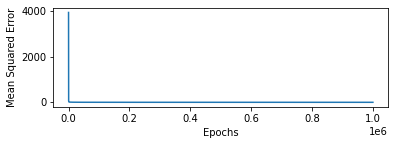

Testing
Testing MSE is  0.32965479182451685
Testing MAE is  0.4672591029420087


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.0001, regularizer=2, learning_rate=0.000025)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000  Cost :  229176.1241950379  MAE Loss : 0.46696805724267
Epoch: 750050  Cost :  229170.08389800024  MAE Loss : 0.4669630429241625
Epoch: 750100  Cost :  229164.0442356952  MAE Loss : 0.46695802884083315
Epoch: 750150  Cost :  229158.00520802772  MAE Loss : 0.46695301499266606
Epoch: 750200  Cost :  229151.96681490247  MAE Loss : 0.4669480013796459
Epoch: 750250  Cost :  229145.929056224  MAE Loss : 0.46694299386923194
Epoch: 750300  Cost :  229139.89193189747  MAE Loss : 0.466938001282208
Epoch: 750350  Cost :  229133.85544182733  MAE Loss : 0.46693300892893436
Epoch: 750400  Cost :  229127.81958591845  MAE Loss : 0.46692801680939505
Epoch: 750450  Cost :  229121.78436407621  MAE Loss : 0.46692302492357535
Epoch: 750500  Cost :  229115.74977620487  MAE Loss : 0.4669180332714594
Epoch: 750550  Cost :  229109.71582220888  MAE Loss : 0.46691304185303173
Epoch: 750600  Cost :  229103.6825019941  MAE Loss : 0.4669080506682774
E

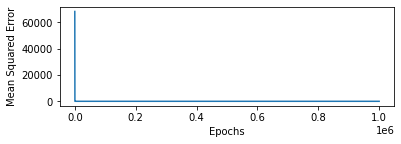

Testing
Testing MSE is  0.3715051018873443
Testing MAE is  0.47926239495003703


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=0.00001, regularizer=2, learning_rate=0.000025)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

### RMSE vs Lambda - Ridge Regression

In [ ]:
def rmse(Y, Y_pred):
    return np.sum((1/Y.shape[0]) * ((Y_pred - Y)**2) )**0.5

rms_train = []
rms_test = []
lam = []
ln_lam = []
for i in range(0, 5000, 250):   
    i = i/10000

    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=i, regularizer=2, display_loss=False, learning_rate=0.000025)
    x_test_trans = GD_Reg_1.transform(test_X)
    y_train_pred = GD_Reg_1.predict(x_train_trans)
    y_test_pred = GD_Reg_1.predict(x_test_trans)
    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train.append(rmse_train)
    rms_test.append(rmse_test)
    lam.append(i)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.0  RMSE train :  0.5223765183501504  RMSE test :  0.5655348455959434
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.025  RMSE train :  0.5629513632533576  RMSE test :  0.5814292288166284
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.05  RMSE train :  0.5476492023883975  RMSE test :  0.57789096229637
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.075  RMSE train :  0.5522987706599246  RMSE test :  0.5801404442581373
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.1  RMSE train :  0.5428956460342237  RMSE test :  0.5725196193568407
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.125  RMSE train :  0.5496640363959976  RMSE test :  0.5814619507921367
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.15  RMSE train :  0.548927179813389  RMSE test :  0.5714211833208582
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.175  RMSE train :  0.5195759396896786  RMSE test :  0.5351027859585323
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.2  RMSE train :  0.49091260726011615  RMSE test :  0.5296654395683947
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.225  RMSE train :  0.5087736411918283  RMSE test :  0.5261203531329918
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.25  RMSE train :  0.5653330604076297  RMSE test :  0.5665377132101761
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.275  RMSE train :  0.6086200982117562  RMSE test :  0.6069463846871697
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.3  RMSE train :  0.5638213286964154  RMSE test :  0.5900011678072531
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.325  RMSE train :  0.5719968594491129  RMSE test :  0.6000690742073089
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.35  RMSE train :  0.5698062306645927  RMSE test :  0.6362495285258752
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.375  RMSE train :  0.49423575201451364  RMSE test :  0.5282583072624913
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.4  RMSE train :  0.564260029737153  RMSE test :  0.6231099901336492
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.425  RMSE train :  0.6120983081627064  RMSE test :  0.6537962390907288
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.45  RMSE train :  0.614315409829865  RMSE test :  0.621237296450941
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.475  RMSE train :  0.5229767335418389  RMSE test :  0.5708218772915606


In [ ]:
for i in range(5000, 25000, 1000):   
    i = i/10000

    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='GD', lam=i, regularizer=2, learning_rate=0.000025)
    x_test_trans = GD_Reg_1.transform(test_X)

    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train.append(rmse_train)
    rms_test.append(rmse_test)
    lam.append(i)

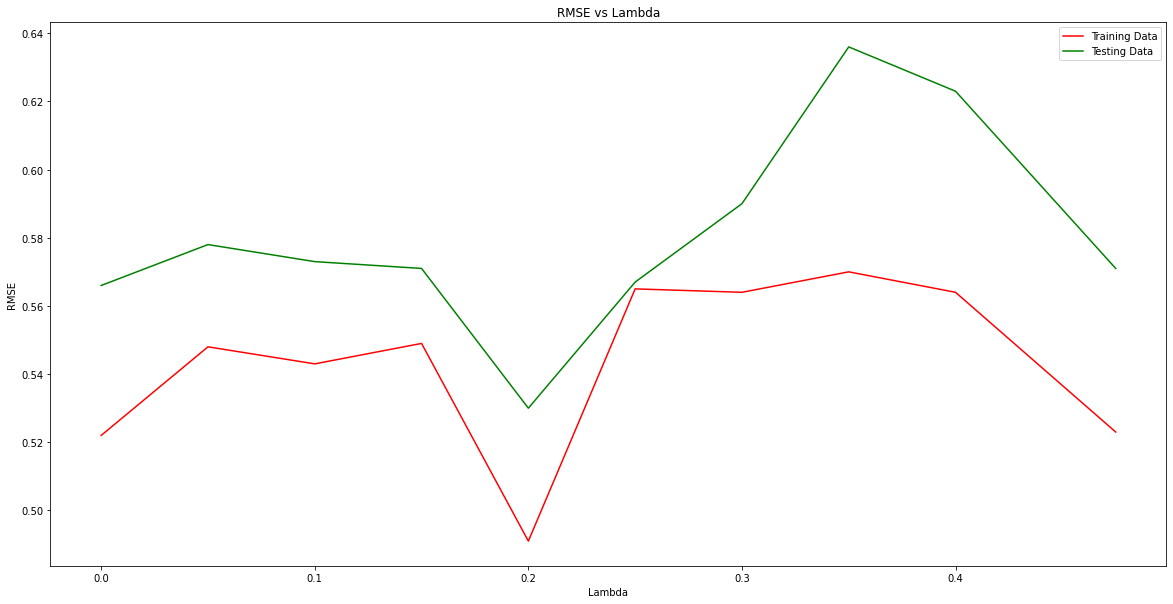

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(l1, rms_tr1, "r", label="Training Data")
ax.plot(l1, rms_t1, "g", label = "Testing Data")
plt.title("RMSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSE")
leg = ax.legend()
plt.show()

In [ ]:
rms_results = []
rms_results.append(l1)
rms_results.append(rms_tr1)
rms_results.append(rms_t1)
rms_results = np.array(rms_results)
file = '/content/gdrive/My Drive/3-1/FoDS/FODSAssignment/rmseVsLambda_ridge.csv'
np.savetxt(file, rms_results, delimiter=",")

## Model - SGD

### SGD

In [ ]:
class PolynomialRegression_Regularizer():

    def __init__(self, degree):
        self.w = None
        self.degree = degree

    def transform(self,X):
        '''
        Transforms the features to degre d polynomial features
        '''
        X_trans = np.ones((len(X[:,1]), 1), dtype=int) 
        for i in range(self.degree+1):
            for j in range(self.degree+1-i):
                if i!=0 or j!=0:
                    t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
                    X_trans = np.concatenate((X_trans, t.T), axis=1)
        return X_trans

    def polynomial(self, X):    
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return np.sum((y-y_pred)**2)/y.shape[0]

    def grad_w(self, x, y, regularizer=None, lam=0):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        m = X.shape[0]
        if regularizer is None:
            return (1/m)*x.T.dot(y_pred - y)
        elif regularizer==1:
            return (1/m)*x.T.dot(y_pred - y) + ( (lam/2*m) * ( np.sign(self.w) ) )
        elif regularizer==2:
            return (1/m)*x.T.dot(y_pred - y) + ( (lam/m) * ( self.w ) )

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)
        print("Testing MSE is ", test_loss)
        mae = (1/y_test.shape[0])*np.sum(np.absolute(y_pred-y_test))
        print("Testing MAE is ", mae)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, lam = 0, regularizer=None, display_loss=True, printValues=True):

        count=0
        m = X.shape[0]

        self.w = np.random.randn(X.shape[1],)

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            
            dw = 0
            if learning == 'GD':
                
                if regularizer==None:

                    y_estimated = self.predict(X)
                    
                    dw = self.grad_w(X, Y)
                    self.w = self.w - (learning_rate * dw) 
                    
                    error = y_estimated - Y
                    cost = (1 / 2 * m) * np.sum(error ** 2)

                if regularizer==1:

                    y_estimated = self.predict(X)
                    
                    dw = self.grad_w(X, Y, regularizer=1, lam=lam)
                    self.w -= (learning_rate * dw)
                    
                    error = y_estimated - Y
                    lasso = (lam / 2 * m) * np.sum( np.absolute(self.w) )
                    cost = (1 / 2 * m) * np.sum(error ** 2) + lasso
                                
                if regularizer==2:

                    y_estimated = self.predict(X)
                    
                    dw = self.grad_w(X, Y, regularizer=2, lam=lam)
                    self.w -= (learning_rate * dw)
                    
                    error = y_estimated - Y
                    ridge = (lam / 2 * m) * np.sum( np.square(self.w) )
                    cost = (1 / 2 * m) * np.sum(error ** 2) + ridge               

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                Y_pred = self.predict(X)
                dw = x*(Y_pred[randInt] - y) 
                error = Y_pred - Y

                if regularizer==None:
                    self.w -= learning_rate * dw

                elif regularizer==1:
                    self.w -= learning_rate * (dw + (lam/2*m) * ( np.sign(self.w) ) )
                    
                elif regularizer==2:
                    self.w -= learning_rate * (dw + (lam/m) * ( self.w ) )

            if display_loss and learning!='SGD':
                if i%50==0:
                    print('Epoch:', i, ' Cost : ', cost, ' MAE Loss :', (1/m)*np.sum(np.absolute(error)))
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)
            
            elif display_loss and learning=='SGD':
                if i%50==0:
                    print('Epoch:', i, 'MAE Loss :', (1/m)*np.sum(np.absolute(error)))
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

        # self.evaluate(self.X_test,self.y_test)

### Lasso Regression

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 750000 MAE Loss : 2.8113497723861385
Epoch: 750050 MAE Loss : 2.8178243906175666
Epoch: 750100 MAE Loss : 2.7990631353557123
Epoch: 750150 MAE Loss : 2.799578685478923
Epoch: 750200 MAE Loss : 2.8040258679336016
Epoch: 750250 MAE Loss : 2.802092710648162
Epoch: 750300 MAE Loss : 2.805825009594327
Epoch: 750350 MAE Loss : 2.8124912438859084
Epoch: 750400 MAE Loss : 2.8017891309098553
Epoch: 750450 MAE Loss : 2.820762209255732
Epoch: 750500 MAE Loss : 2.8259014298264
Epoch: 750550 MAE Loss : 2.8369326250003306
Epoch: 750600 MAE Loss : 2.811121192346915
Epoch: 750650 MAE Loss : 2.811638134576414
Epoch: 750700 MAE Loss : 2.8123218691571203
Epoch: 750750 MAE Loss : 2.8326802196578957
Epoch: 750800 MAE Loss : 2.825743859587626
Epoch: 750850 MAE Loss : 2.8210004080783615
Epoch: 750900 MAE Loss : 2.817783002902953
Epoch: 750950 MAE Loss : 2.8148337521576723
Epoch: 751000 MAE Loss : 2.806117422773844
Epoch: 751050 MAE Loss : 2.8030053518

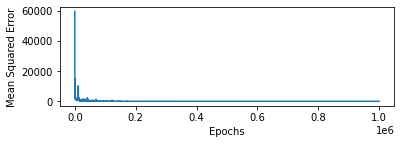

Testing
Testing MSE is  10.500492413901132
Testing MAE is  2.6215981543877254


In [ ]:
GD_Reg_1 = PolynomialRegression_Regularizer(9)
x_train_trans = GD_Reg_1.transform(train_X)
GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='SGD', regularizer=1, lam=0.0001, learning_rate=0.0000001)
x_test_trans = GD_Reg_1.transform(test_X)
GD_Reg_1.evaluate(x_test_trans, test_y)

In [ ]:
def rmse(Y, Y_pred):
    return np.sum((1/Y.shape[0]) * ((Y_pred - Y)**2) )**0.5

rms_train_l = []
rms_test_l = []
lam_l = []
ln_lam = []
for i in range(1, 6):   
    i = i/10

    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='SGD', lam=i, display_loss=False, regularizer=1, learning_rate=0.0000001)
    x_test_trans = GD_Reg_1.transform(test_X)
    y_train_pred = GD_Reg_1.predict(x_train_trans)
    y_test_pred = GD_Reg_1.predict(x_test_trans)
    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train_l.append(rmse_train)
    rms_test_l.append(rmse_test)
    lam_l.append(i)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.1  RMSE train :  0.996282728388924  RMSE test :  1.0033871376686134
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.2  RMSE train :  0.9978622208578922  RMSE test :  1.0058601735329398
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.3  RMSE train :  0.9968189932506488  RMSE test :  1.0041952668384755
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.4  RMSE train :  0.9978368413055193  RMSE test :  1.005912600177237
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.5  RMSE train :  0.9952536553738891  RMSE test :  1.001795089430064


In [ ]:
for i in range(100, 10, -25):   
    i = i/1000

    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='SGD', lam=i, display_loss=False, regularizer=1, learning_rate=0.0000001)
    x_test_trans = GD_Reg_1.transform(test_X)
    y_train_pred = GD_Reg_1.predict(x_train_trans)
    y_test_pred = GD_Reg_1.predict(x_test_trans)
    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train_l.insert(0, rmse_train)
    rms_test_l.insert(0, rmse_test)
    lam_l.insert(0, i)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.1  RMSE train :  0.9702427948346364  RMSE test :  0.9677567247423953
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.075  RMSE train :  0.9835612585120941  RMSE test :  0.9839999206910953
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.05  RMSE train :  0.9770689622734693  RMSE test :  0.9753099592933332
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.025  RMSE train :  1.4287697640444694  RMSE test :  1.5713170926210476


In [ ]:
rms_train_l

[1.4287697640444694,
 0.9770689622734693,
 0.9835612585120941,
 0.9702427948346364,
 0.996282728388924,
 0.9978622208578922,
 0.9968189932506488,
 0.9978368413055193,
 0.9952536553738891]

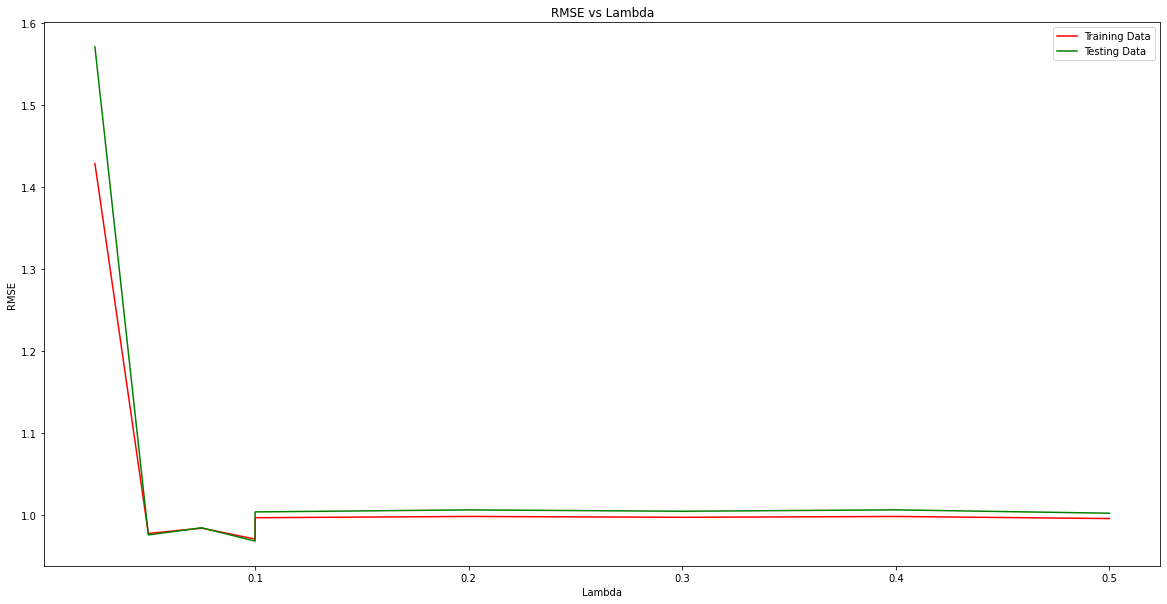

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(lam_l, rms_train_l, "r", label="Training Data")
ax.plot(lam_l, rms_test_l, "g", label = "Testing Data")
plt.title("RMSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSE")
leg = ax.legend()
plt.show()

In [ ]:
rms_results1 = []
rms_results1.append(lam_l)
rms_results1.append(rms_train_l)
rms_results1.append(rms_test_l)
rms_results1 = np.array(rms_results1)
file = '/content/gdrive/My Drive/3-1/FoDS/FODSAssignment/rmseVsLambda_lasso_sgd.csv'
np.savetxt(file, rms_results1, delimiter=",")

### Ridge Regression

In [ ]:
def rmse(Y, Y_pred):
    return np.sum((1/Y.shape[0]) * ((Y_pred - Y)**2) )**0.5

rms_train_l = []
rms_test_l = []
lam_l = []
ln_lam = []
for i in range(1, 6):   
    i = i/10

    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='SGD', lam=i, display_loss=False, regularizer=2, learning_rate=0.0000001)
    x_test_trans = GD_Reg_1.transform(test_X)
    y_train_pred = GD_Reg_1.predict(x_train_trans)
    y_test_pred = GD_Reg_1.predict(x_test_trans)
    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train_l.append(rmse_train)
    rms_test_l.append(rmse_test)
    lam_l.append(i)

for i in range(75, 0, -25):   
    i = i/1000

    GD_Reg_1 = PolynomialRegression_Regularizer(9)
    x_train_trans = GD_Reg_1.transform(train_X)
    GD_Reg_1.fit(x_train_trans, train_y, epochs = 1000000, learning='SGD', lam=i, display_loss=False, regularizer=2, learning_rate=0.0000001)
    x_test_trans = GD_Reg_1.transform(test_X)
    y_train_pred = GD_Reg_1.predict(x_train_trans)
    y_test_pred = GD_Reg_1.predict(x_test_trans)
    rmse_train = rmse(train_y, y_train_pred)
    rmse_test = rmse(test_y, y_test_pred)
    print('Lamdba : ', i, ' RMSE train : ', rmse_train, ' RMSE test : ', rmse_test)
    rms_train_l.insert(0, rmse_train)
    rms_test_l.insert(0, rmse_test)
    lam_l.insert(0, i)

Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.1  RMSE train :  3.34768660265265  RMSE test :  2.9500758031621377
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.2  RMSE train :  2.4805447657757047  RMSE test :  2.518860490491065
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.3  RMSE train :  3.0117106900840516  RMSE test :  2.9958892666412793
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.4  RMSE train :  3.0475788002383193  RMSE test :  3.8648610918228945
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.5  RMSE train :  2.688524644347479  RMSE test :  3.520542775678615
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.075  RMSE train :  3.4015271538989684  RMSE test :  3.439581708264876
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.05  RMSE train :  3.3658478652890573  RMSE test :  4.194052515035955
Training...


  0%|          | 0/1000000 [00:00<?, ?epoch/s]

Testing
Lamdba :  0.025  RMSE train :  6.564507007498551  RMSE test :  9.449471161328578


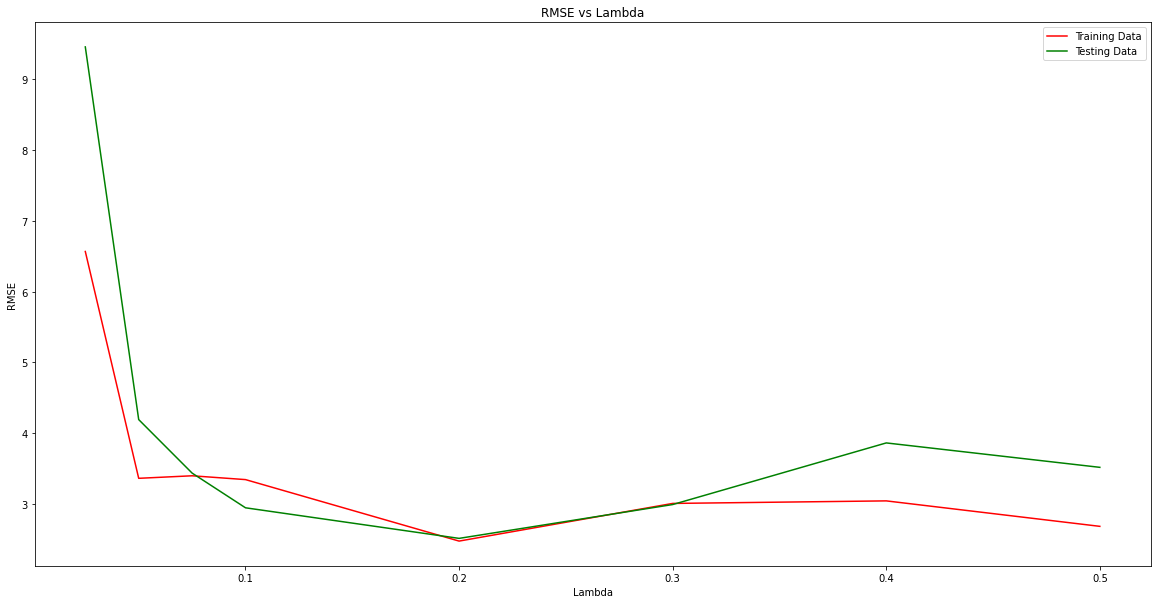

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(lam_l, rms_train_l, "r", label="Training Data")
ax.plot(lam_l, rms_test_l, "g", label = "Testing Data")
plt.title("RMSE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSE")
leg = ax.legend()
plt.show()

In [ ]:
rms_results2 = []
rms_results2.append(lam_l)
rms_results2.append(rms_train_l)
rms_results2.append(rms_test_l)
rms_results2 = np.array(rms_results2)
file = '/content/gdrive/My Drive/3-1/FoDS/FODSAssignment/rmseVsLambda_ridge_sgd.csv'
np.savetxt(file, rms_results2, delimiter=",")